# Machine Learning Modeling 
* `non-stationary` & `highly-correlated` 

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd 
import numpy as np
pd.set_option("max_rows", 500)
pd.set_option("max_columns", 500)
pd.set_option('float_format', '{:f}'.format)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 

plt.style.use('seaborn')
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)


import dataload

import os 
import random
import datetime
from tqdm import tqdm 
from functools import reduce

# modeling 
from tslearn.clustering import TimeSeriesKMeans

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

import shap 

In [2]:
nonst_high = pd.read_csv("nonst_high_0616.csv", encoding="cp949")
weather = pd.read_csv("weather_final2.csv", encoding="cp949")
loc_weight = pd.read_csv("population_wieght.csv", encoding="cp949")

print(nonst_high.shape, weather.shape, loc_weight.shape)

print("*", nonst_high.sm_cat.nunique())
nonst_high.head()

(1179438, 52) (11680, 29) (9, 2)
* 176


,date,sex,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50
0,2018-01-01,1,냉난방가전,가열식 가습기,1.000000,24.759610,10.693870,4.091370,0.000000,0.000000,0.044400,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,2018-01-01,1,냉난방가전,가열식 가습기,0.000000,17.938930,12.429690,6.352940,0.000000,0.512820,0.424170,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,2018-01-01,1,냉난방가전,가열식 가습기,3.000000,11.070550,13.022490,4.880370,0.000000,0.406500,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,2018-01-01,1,냉난방가전,가열식 가습기,0.000000,12.605040,11.690800,4.533500,1.219510,0.909090,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,2018-01-01,1,냉난방가전,가열식 가습기,0.000000,4.255310,13.927120,5.478870,0.000000,0.000000,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [4]:
nonst_high = nonst_high[nonst_high.qty > 0]
print(nonst_high.shape)
print("*", nonst_high.sm_cat.nunique())

(987563, 52)
* 176


In [5]:
tqdm.pandas()
nonst_high['date'] = nonst_high['date'].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d'))
weather['날짜'] = weather['날짜'].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d'))
weather = weather.rename(columns={"날짜" : "date"})

100%|██████████| 11680/11680 [00:00<00:00, 14132.91it/s]


# TimeSeries Clustering 

In [172]:
nonst_high['year'] = nonst_high['date'].progress_apply(lambda x : x.year)
buy_2018 = nonst_high[nonst_high.year==2018][['date', 'big_cat', 'sm_cat', 'qty']]
buy_2019 = nonst_high[nonst_high.year==2019][['date', 'big_cat', 'sm_cat', 'qty']]
nonst_high = nonst_high.drop('year', axis=1)

buy_2018.shape, buy_2019.shape

100%|██████████| 1179438/1179438 [00:04<00:00, 271024.22it/s]


((586427, 4), (593011, 4))

In [173]:
buy_2018["date"] = buy_2018["date"] + datetime.timedelta(days=-1)
buy_2018["date"] = buy_2018["date"].progress_apply(lambda x : x.replace(year=2018, month=12, day=31) if x==datetime.date(2017, 12, 31) else x)

100%|██████████| 586427/586427 [00:02<00:00, 253358.20it/s]


In [174]:
buy_2018.date.nunique()

365

In [175]:
buy_2018["date"] = buy_2018["date"].apply(lambda x : str(x)[5:])
buy_2019["date"] = buy_2019["date"].apply(lambda x : str(x)[5:])

In [176]:
buy_2018 = pd.pivot_table(buy_2018, index="sm_cat", columns="date", values="qty")
buy_2019 = pd.pivot_table(buy_2019, index="sm_cat", columns="date", values="qty")

print(buy_2018.shape, buy_2019.shape)

buy_2018 = buy_2018.fillna(0)
buy_2019 = buy_2019.fillna(0)

(176, 365) (176, 365)


In [177]:
buy_2018.head()

date,01-01 00:00:00,01-02 00:00:00,01-03 00:00:00,01-04 00:00:00,01-05 00:00:00,01-06 00:00:00,01-07 00:00:00,01-08 00:00:00,01-09 00:00:00,01-10 00:00:00,01-11 00:00:00,01-12 00:00:00,01-13 00:00:00,01-14 00:00:00,01-15 00:00:00,01-16 00:00:00,01-17 00:00:00,01-18 00:00:00,01-19 00:00:00,01-20 00:00:00,01-21 00:00:00,01-22 00:00:00,01-23 00:00:00,01-24 00:00:00,01-25 00:00:00,01-26 00:00:00,01-27 00:00:00,01-28 00:00:00,01-29 00:00:00,01-30 00:00:00,01-31 00:00:00,02-01 00:00:00,02-02 00:00:00,02-03 00:00:00,02-04 00:00:00,02-05 00:00:00,02-06 00:00:00,02-07 00:00:00,02-08 00:00:00,02-09 00:00:00,02-10 00:00:00,02-11 00:00:00,02-12 00:00:00,02-13 00:00:00,02-14 00:00:00,02-15 00:00:00,02-16 00:00:00,02-17 00:00:00,02-18 00:00:00,02-19 00:00:00,02-20 00:00:00,02-21 00:00:00,02-22 00:00:00,02-23 00:00:00,02-24 00:00:00,02-25 00:00:00,02-26 00:00:00,02-27 00:00:00,02-28 00:00:00,03-01 00:00:00,03-02 00:00:00,03-03 00:00:00,03-04 00:00:00,03-05 00:00:00,03-06 00:00:00,03-07 00:00:00,03-08 00:00:00,03-09 00:00:00,03-10 00:00:00,03-11 00:00:00,03-12 00:00:00,03-13 00:00:00,03-14 00:00:00,03-15 00:00:00,03-16 00:00:00,03-17 00:00:00,03-18 00:00:00,03-19 00:00:00,03-20 00:00:00,03-21 00:00:00,03-22 00:00:00,03-23 00:00:00,03-24 00:00:00,03-25 00:00:00,03-26 00:00:00,03-27 00:00:00,03-28 00:00:00,03-29 00:00:00,03-30 00:00:00,03-31 00:00:00,04-01 00:00:00,04-02 00:00:00,04-03 00:00:00,04-04 00:00:00,04-05 00:00:00,04-06 00:00:00,04-07 00:00:00,04-08 00:00:00,04-09 00:00:00,04-10 00:00:00,04-11 00:00:00,04-12 00:00:00,04-13 00:00:00,04-14 00:00:00,04-15 00:00:00,04-16 00:00:00,04-17 00:00:00,04-18 00:00:00,04-19 00:00:00,04-20 00:00:00,04-21 00:00:00,04-22 00:00:00,04-23 00:00:00,04-24 00:00:00,04-25 00:00:00,04-26 00:00:00,04-27 00:00:00,04-28 00:00:00,04-29 00:00:00,04-30 00:00:00,05-01 00:00:00,05-02 00:00:00,05-03 00:00:00,05-04 00:00:00,05-05 00:00:00,05-06 00:00:00,05-07 00:00:00,05-08 00:00:00,05-09 00:00:00,05-10 00:00:00,05-11 00:00:00,05-12 00:00:00,05-13 00:00:00,05-14 00:00:00,05-15 00:00:00,05-16 00:00:00,05-17 00:00:00,05-18 00:00:00,05-19 00:00:00,05-20 00:00:00,05-21 00:00:00,05-22 00:00:00,05-23 00:00:00,05-24 00:00:00,05-25 00:00:00,05-26 00:00:00,05-27 00:00:00,05-28 00:00:00,05-29 00:00:00,05-30 00:00:00,05-31 00:00:00,06-01 00:00:00,06-02 00:00:00,06-03 00:00:00,06-04 00:00:00,06-05 00:00:00,06-06 00:00:00,06-07 00:00:00,06-08 00:00:00,06-09 00:00:00,06-10 00:00:00,06-11 00:00:00,06-12 00:00:00,06-13 00:00:00,06-14 00:00:00,06-15 00:00:00,06-16 00:00:00,06-17 00:00:00,06-18 00:00:00,06-19 00:00:00,06-20 00:00:00,06-21 00:00:00,06-22 00:00:00,06-23 00:00:00,06-24 00:00:00,06-25 00:00:00,06-26 00:00:00,06-27 00:00:00,06-28 00:00:00,06-29 00:00:00,06-30 00:00:00,07-01 00:00:00,07-02 00:00:00,07-03 00:00:00,07-04 00:00:00,07-05 00:00:00,07-06 00:00:00,07-07 00:00:00,07-08 00:00:00,07-09 00:00:00,07-10 00:00:00,07-11 00:00:00,07-12 00:00:00,07-13 00:00:00,07-14 00:00:00,07-15 00:00:00,07-16 00:00:00,07-17 00:00:00,07-18 00:00:00,07-19 00:00:00,07-20 00:00:00,07-21 00:00:00,07-22 00:00:00,07-23 00:00:00,07-24 00:00:00,07-25 00:00:00,07-26 00:00:00,07-27 00:00:00,07-28 00:00:00,07-29 00:00:00,07-30 00:00:00,07-31 00:00:00,08-01 00:00:00,08-02 00:00:00,08-03 00:00:00,08-04 00:00:00,08-05 00:00:00,08-06 00:00:00,08-07 00:00:00,08-08 00:00:00,08-09 00:00:00,08-10 00:00:00,08-11 00:00:00,08-12 00:00:00,08-13 00:00:00,08-14 00:00:00,08-15 00:00:00,08-16 00:00:00,08-17 00:00:00,08-18 00:00:00,08-19 00:00:00,08-20 00:00:00,08-21 00:00:00,08-22 00:00:00,08-23 00:00:00,08-24 00:00:00,08-25 00:00:00,08-26 00:00:00,08-27 00:00:00,08-28 00:00:00,08-29 00:00:00,08-30 00:00:00,08-31 00:00:00,09-01 00:00:00,09-02 00:00:00,09-03 00:00:00,09-04 00:00:00,09-05 00:00:00,09-06 00:00:00,09-07 00:00:00,09-08 00:00:00,09-09 00:00:00,09-10 00:00:00,09-11 00:00:00,09-12 00:00:00,09-13 00:00:00,09-14 00:00:00,09-15 00:00:00,09-16 00:00:00,09-17 00:00:00,09-18 00:00:00,09-19 00:00:00,09-20 00:00:00,09-21 00:00:00,09-22 00:00:00,09-23 00:00:00,09-24

## 1. 데이터 정규화 

In [178]:
def normalize_df(df) : 
    avg_lst = []; std_lst = []
    for idx, row in tqdm(df.iterrows()):
        avg_lst.append(row.mean())
        std_lst.append(row.std())

    df['avg'] = avg_lst
    df['std'] = std_lst


    for i in tqdm(range(len(df))):
        for j in range(365):
            df.iloc[i,j] = (df.iloc[i,j] - df.iloc[i,365])/df.iloc[i,366] 

    df = df.drop(['avg','std'], axis=1)
    return df 

In [179]:
buy_2018 = normalize_df(buy_2018)
buy_2019 = normalize_df(buy_2019)

176it [00:00, 7037.76it/s]
100%|██████████| 176/176 [00:09<00:00, 17.96it/s]
176it [00:00, 8348.38it/s]
100%|██████████| 176/176 [00:09<00:00, 18.33it/s]


In [182]:
ts = (buy_2018 + buy_2019)/2
ts.shape

(176, 365)

## 2. 최적 k 찾기 

In [181]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in tqdm(range(2, 7)): 
        ts_clustering = TimeSeriesKMeans(n_clusters=i, max_iter=param_max_iter, random_state=1234, metric = 'dtw')
        ts_clustering.fit(data)
        distortions.append(ts_clustering.inertia_)

    plt.plot(range(2, 7), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

100%|██████████| 5/5 [03:06<00:00, 37.38s/it]


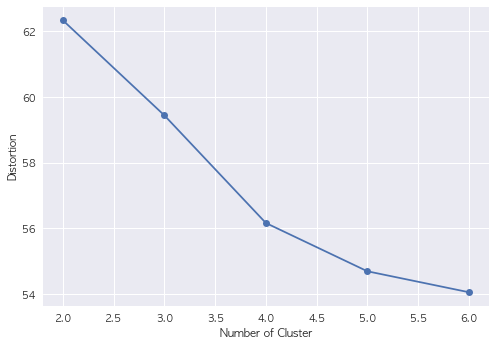

CPU times: user 8min 56s, sys: 1min 12s, total: 10min 8s
Wall time: 3min 6s


In [185]:
%time  visualize_elbowmethod(ts)

## 3. TimeSeries K-means Clustering 

In [186]:
model1 = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=300, random_state=1234, n_jobs=-1)

for i in tqdm(range(len(ts))) : 
    model1.fit(ts)

100%|██████████| 176/176 [1:39:57<00:00, 34.08s/it]


In [187]:
ts_result = pd.DataFrame({
    'sm_cat' : ts.index, 
    'cluster' : model1.labels_
})

In [188]:
ts_result.cluster.value_counts()

0    66
3    42
1    41
2    27
Name: cluster, dtype: int64

In [189]:
# cluster 0 : 여름 (66)
ts_result[ts_result.cluster==0]

,sm_cat,cluster
1,감/홍시,0
4,감자,0
6,건대추,0
7,건포도,0
12,계란,0
13,고추/피망/파프리카,0
15,공기정화 용품,0
27,기타 주스류,0
28,김치류,0
32,남성 선케어,0


In [190]:
# cluster 1 
ts_result[ts_result.cluster==1]

,sm_cat,cluster
10,견과류 땅콩,1
16,과채 음료/주스,1
19,기능성 아이케어 화장품,1
22,기초 화장용 로션,1
23,기초 화장용 미스트,1
24,기초 화장용 에센스,1
30,남성 로션,1
31,남성 메이크업,1
33,남성 세트,1
34,남성 쉐이빙,1


In [191]:
# cluster 2 
ts_result[ts_result.cluster==2]

,sm_cat,cluster
5,갓김치,2
9,견과류,2
20,기능성 영양보습 화장품,2
42,다이어트보조식,2
44,닭 양념육,2
46,더치커피,2
64,바나나/파인애플/망고,2
66,바디 세트,2
72,백김치,2
76,벽걸이형 냉온풍기,2


In [192]:
# cluster 3 
ts_result[ts_result.cluster==3]

,sm_cat,cluster
0,가열식 가습기,3
2,감귤/한라봉/오렌지,3
3,감말랭이,3
8,게장류,3
11,견과류 밤,3
14,곡물차,3
17,국내산 돈육,3
18,굴 생물,3
21,기능성 화장품 세트,3
25,기초 화장용 오일/앰플,3


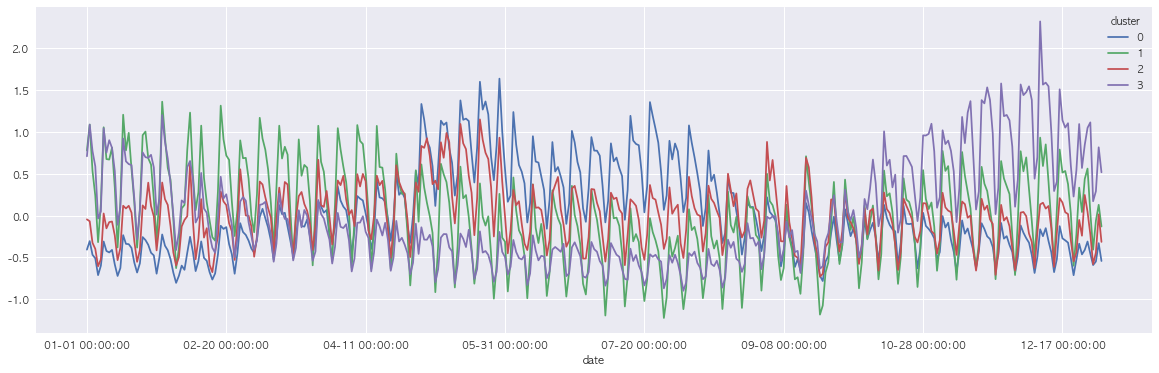

In [193]:
ts["cluster"] = model1.labels_

plt.rcParams["figure.figsize"]=(20,6)
ts.groupby(['cluster']).mean().T.plot()
plt.show()

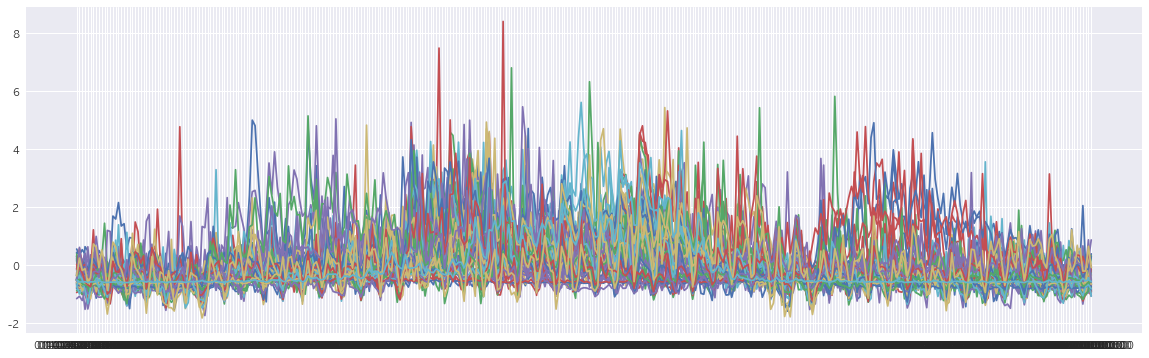

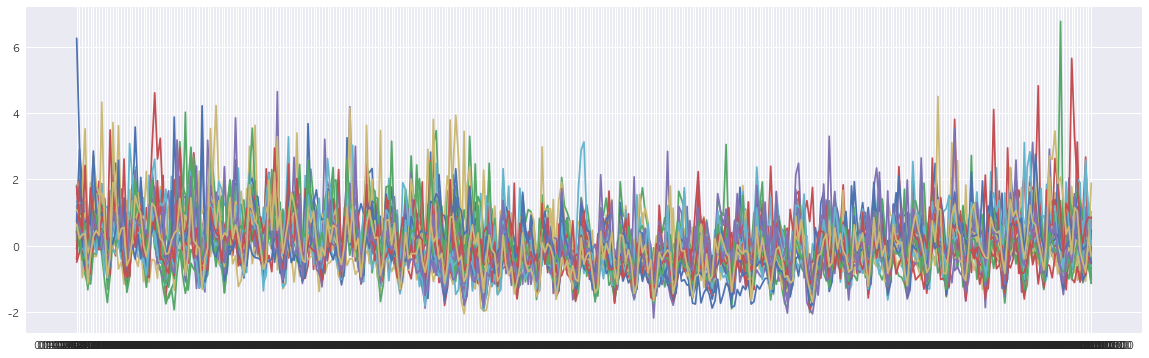

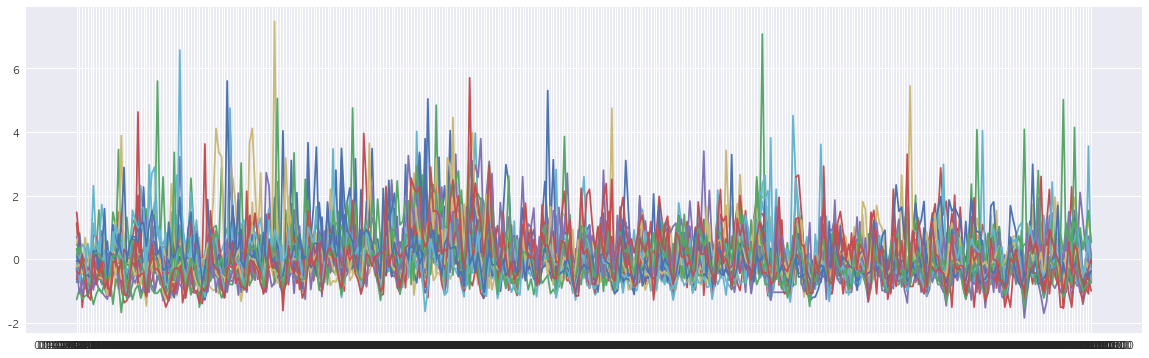

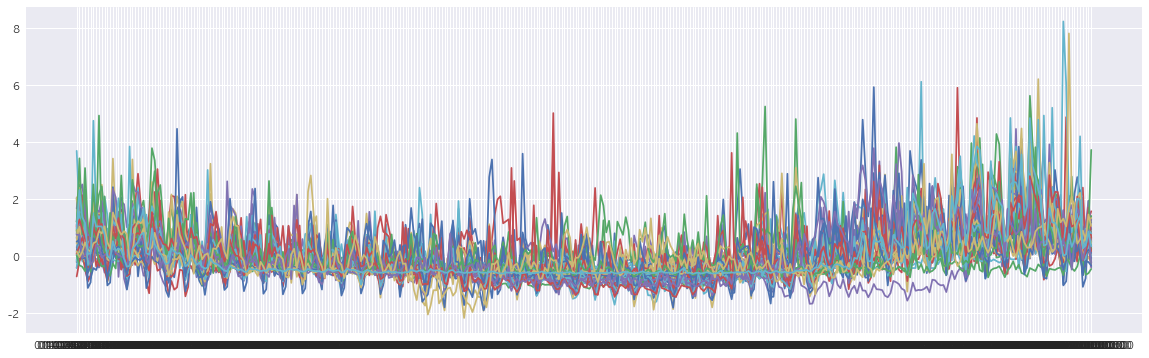

In [194]:
for i in range(4):
    clusters = ts[ts['cluster']==i]
    clusters.drop(['cluster'], axis=1, inplace=True)
    plt.figure(figsize=(20,6))
    plt.plot(clusters.T)
    plt.show

In [195]:
ts["cluster"] = model1.labels_
ts.to_csv("tsclustering_0617.csv", encoding='cp949')

In [6]:
ts = pd.read_csv("tsclustering_0617.csv", encoding='cp949')

# Modeling 

In [7]:
def region_weather(loc):
    weather_true = weather.drop(['연', '월', '일', '분기', '요일', '공휴일명', '공휴일여부', '주말여부', '계절', 'year', 'month'], axis=1) 
    weather1 = pd.pivot_table(weather_true[weather_true['지역'] == loc], index='date', columns='지역').reset_index(level=0)
    weather1.columns = weather1.columns.get_level_values(0)
    return weather1

In [8]:
def cluster_df(big_cat, product_cat) : 
    
    '''
    big_cat : TimeSeries Clustering 결과 파일 (pivot table 형태의 dataframe)
    product_cat : big_category 에 해당되는 dataframe 
    '''
    
    cluster0 = big_cat[big_cat["cluster"] == 0] 
    cluster1 = big_cat[big_cat["cluster"] == 1]
    cluster2 = big_cat[big_cat["cluster"] == 2]
    cluster3 = big_cat[big_cat["cluster"] == 3]
    
    cluster0 = list(cluster0['sm_cat']) 
    cluster1 = list(cluster1['sm_cat']) 
    cluster2 = list(cluster2['sm_cat']) 
    cluster3 = list(cluster3['sm_cat']) 
    
    product_cat = product_cat.rename(columns = {'PM10' : 'PM10_index', 'PM25' : 'PM25_index'})
    
    big_c0 = product_cat[product_cat['sm_cat'].isin(cluster0)].reset_index(drop=True)
    big_c1 = product_cat[product_cat['sm_cat'].isin(cluster1)].reset_index(drop=True)
    big_c2 = product_cat[product_cat['sm_cat'].isin(cluster2)].reset_index(drop=True)
    big_c3 = product_cat[product_cat['sm_cat'].isin(cluster3)].reset_index(drop=True)
    
    return big_c0, big_c1, big_c2, big_c3

In [9]:
bty_c0, bty_c1, bty_c2, bty_c3 = cluster_df(ts, nonst_high)
bty_c0.shape, bty_c1.shape, bty_c2.shape, bty_c3.shape

((359845, 52), (267797, 52), (139599, 52), (220322, 52))

In [10]:
# sm_cat one hot encoding 
bty_c0 = pd.get_dummies(bty_c0, columns=['sm_cat'], drop_first = True)
bty_c1 = pd.get_dummies(bty_c1, columns=['sm_cat'], drop_first = True)
bty_c2 = pd.get_dummies(bty_c2, columns=['sm_cat'], drop_first = True)
bty_c3 = pd.get_dummies(bty_c3, columns=['sm_cat'], drop_first = True)

bty_c0.shape, bty_c1.shape, bty_c2.shape, bty_c3.shape

((359845, 116), (267797, 91), (139599, 77), (220322, 92))

In [11]:
def loc_df(cluster) : 
    
    '''
    - 수도권: 서울
    - 강원: 강릉
    - 경북: 대구
    - 경남: 부산
    - 전남: 광주
    - 전북: 전주 
    - 충남: 대전
    - 충북: 청주 
    - 제주: 제주
    '''
    
    c0_1 = cluster.merge(region_weather('서울'), on="date", how='left')
    c0_2 = cluster.merge(region_weather('강릉'), on="date", how='left')
    c0_3 = cluster.merge(region_weather('대구'), on="date", how='left')
    c0_4 = cluster.merge(region_weather('부산'), on="date", how='left')
    c0_5 = cluster.merge(region_weather('광주'), on="date", how='left')
    c0_6 = cluster.merge(region_weather('전주'), on="date", how='left')
    c0_7 = cluster.merge(region_weather('대전'), on="date", how='left')
    c0_8 = cluster.merge(region_weather('청주'), on="date", how='left')
    c0_9 = cluster.merge(region_weather('제주'), on="date", how='left')  
    
    return c0_1, c0_2, c0_3, c0_4, c0_5, c0_6, c0_7, c0_8, c0_9

In [12]:
def sampling(data):
    
    # 랜덤으로 요일 선택
    np.random.seed(1234)
    sample_day = []; sample_idx = []
    count = 730//7 
    day_list = day_list = [1,2,3,4,5,6,7]
    sample_list = [random.choice(day_list) for i in range(count)]

    # 랜덤으로 선택된 요일의 날짜
    start = datetime.datetime(2018, 1, 1)
    for days in sample_list:
        sample_day.append(start + datetime.timedelta(days = days))
        start = start + datetime.timedelta(weeks = 1)

    # 샘플링
    for date in sample_day:
        sample_idx.extend(data[data['date']==date].index)
        
    all_idx = data.index.tolist()
    train_idx = list(set(all_idx) - set(sample_idx))
    
    return data.iloc[train_idx].reset_index(drop=True), data.iloc[sample_idx].reset_index(drop=True)

In [13]:
def df_preprocessing(train, test) : 
    train = train.drop(['date', 'big_cat'], axis=1) ; test = test.drop(['date', 'big_cat'], axis=1)

    # X, y 
    X_train , y_train = train.drop('qty', axis=1), train.qty 
    X_test , y_test = test.drop('qty', axis=1), test.qty 
    
    # continuous / discrete 
    dummy = list(X_train.columns[X_train.columns.str.contains("연|월|분기|요일|공휴일여부|주말여부|계절|age|sm_cat_|강수여부|폭염여부|sex")])
    train_continuous = X_train.drop(dummy, axis=1) ; test_continuous = X_test.drop(dummy, axis=1) 
    train_discrete = X_train[dummy] ; test_discrete = X_test[dummy]
    
    # standardization 
    std_scaler = StandardScaler() 
    train_std = std_scaler.fit_transform(train_continuous) ; test_std = std_scaler.transform(test_continuous)
    train_std = pd.DataFrame(train_std, columns = train_continuous.columns) ; test_std = pd.DataFrame(test_std, columns = test_continuous.columns)
    
    # concat dummy variable 
    train_std = pd.concat([train_std, train_discrete], axis=1) ; test_std = pd.concat([test_std, test_discrete], axis=1)
        
    return train_std, y_train, test_std, y_test

# Modeling 

In [14]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

In [15]:
def loc_weighted_sum(df1, df2, df3, df4, df5, df6, df7, df8, df9) : 
    df = df1 * loc_weight.loc[0]["final_가중치"] + df2 * loc_weight.loc[1]["final_가중치"] + df3 * loc_weight.loc[2]["final_가중치"]
    + df4 * loc_weight.loc[3]["final_가중치"] + df5 * loc_weight.loc[4]["final_가중치"] + df6 * loc_weight.loc[5]["final_가중치"]
    + df7 * loc_weight.loc[6]["final_가중치"] + df8 * loc_weight.loc[7]["final_가중치"] + df9 * loc_weight.loc[8]["final_가중치"]       
    return df 

## 1. Cluster0 : 겨울 

In [18]:
def location_ensemble(df, model, shapvalue=False) : 
    train, test = sampling(df)
    train1, train2, train3, train4, train5, train6, train7, train8, train9 = loc_df(train) 
    test1, test2, test3, test4, test5, test6, test7, test8, test9 = loc_df(test) 
    
    if not train1.shape==train2.shape==train3.shape==train4.shape==train5.shape==train6.shape==train7.shape==train8.shape==train9.shape : 
        raise Exception("Check Again!")
    if not test1.shape==test2.shape==test3.shape==test4.shape==test5.shape==test6.shape==test7.shape==test8.shape==test9.shape : 
        raise Exception("Check Again!")

    print("Data Shape : ", train1.shape, test1.shape) 

    print("\n", "===== Finish Data Preprocessing =====")
    print()
       
        
    # 1. 서울 
    X_train1, y_train1, X_test1, y_test1 = df_preprocessing(train1, test1)
    
    model1 = model
    model1.fit(X_train1, y_train1)
    y_pred1 = model1.predict(X_test1)
    
    fe1 = pd.DataFrame({'col' : X_train1.columns, 'feature importance' : model1.feature_importances_})
    fe1 = fe1[~fe1.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe1 = fe1.set_index('col').squeeze(axis=1)
    
    if shapvalue : 
        explainer = shap.TreeExplainer(model1)
        shap_values = explainer1.shap_values(X_train1)     
    
    print("* Finish 서울 *")
    
    
    # 2. 강원 
    X_train2, y_train2, X_test2, y_test2 = df_preprocessing(train2, test2)
    
    model2 = model
    model2.fit(X_train2, y_train2)
    y_pred2 = model2.predict(X_test2)    
    
    fe2 = pd.DataFrame({'col' : X_train2.columns, 'feature importance' : model2.feature_importances_})
    fe2 = fe2[~fe2.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe2 = fe2.set_index('col').squeeze(axis=1)
    
    print("* Finish 강원 *")


    # 3. 경북 
    X_train3, y_train3, X_test3, y_test3 = df_preprocessing(train3, test3)
    
    model3 = model
    model3.fit(X_train3, y_train3)
    y_pred3 = model3.predict(X_test3)   
    
    fe3 = pd.DataFrame({'col' : X_train3.columns, 'feature importance' : model3.feature_importances_})
    fe3 = fe3[~fe3.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe3 = fe3.set_index('col').squeeze(axis=1)

    print("* Finish 경북 *")
    

    # 4. 경남 
    X_train4, y_train4, X_test4, y_test4 = df_preprocessing(train4, test4)
    
    model4 = model
    model4.fit(X_train4, y_train4)
    y_pred4 = model4.predict(X_test4) 
    
    fe4 = pd.DataFrame({'col' : X_train4.columns, 'feature importance' : model4.feature_importances_})
    fe4 = fe4[~fe4.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe4 = fe4.set_index('col').squeeze(axis=1)

    print("* Finish 경남 *")
    
    
    # 5. 전남 
    X_train5, y_train5, X_test5, y_test5 = df_preprocessing(train5, test5)
    
    model5 = model
    model5.fit(X_train5, y_train5)
    y_pred5 = model5.predict(X_test5)
    
    fe5 = pd.DataFrame({'col' : X_train5.columns, 'feature importance' : model5.feature_importances_})
    fe5 = fe5[~fe5.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe5 = fe5.set_index('col').squeeze(axis=1)
    
    print("* Finish 전남 *")
    

    # 6. 전북 
    X_train6, y_train6, X_test6, y_test6 = df_preprocessing(train6, test6)
    
    model6 = model
    model6.fit(X_train6, y_train6)
    y_pred6 = model6.predict(X_test6)
    
    fe6 = pd.DataFrame({'col' : X_train6.columns, 'feature importance' : model6.feature_importances_})
    fe6 = fe6[~fe6.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe6 = fe6.set_index('col').squeeze(axis=1)
      
    print("* Finish 전북 *")
    
    
    # 7. 충남 
    X_train7, y_train7, X_test7, y_test7 = df_preprocessing(train7, test7)
    
    model7 = model
    model7.fit(X_train7, y_train7)
    y_pred7 = model7.predict(X_test7)   
    
    fe7 = pd.DataFrame({'col' : X_train7.columns, 'feature importance' : model7.feature_importances_})
    fe7 = fe7[~fe7.col.str.contains('sm_cat_')].reset_index(drop=True) 
    fe7 = fe7.set_index('col').squeeze(axis=1)
    
    print("* Finish 충남 *")


    # 8. 충북 
    X_train8, y_train8, X_test8, y_test8 = df_preprocessing(train8, test8)
    
    model8 = model
    model8.fit(X_train8, y_train8)
    y_pred8 = model8.predict(X_test8)   
    
    fe8 = pd.DataFrame({'col' : X_train8.columns, 'feature importance' : model8.feature_importances_})
    fe8 = fe8[~fe8.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe8 = fe8.set_index('col').squeeze(axis=1)
    
    print("* Finish 충북 *")
    

    # 9. 제주 
    X_train9, y_train9, X_test9, y_test9 = df_preprocessing(train9, test9)
    
    model9 = model
    model9.fit(X_train9, y_train9)
    y_pred9 = model9.predict(X_test9) 
    
    fe9 = pd.DataFrame({'col' : X_train9.columns, 'feature importance' : model9.feature_importances_})
    fe9 = fe9[~fe9.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe9 = fe9.set_index('col').squeeze(axis=1)
    
    print("* Finish 제주 *")
    
    
    # ensemble 
    y_true = loc_weighted_sum(y_test1, y_test2, y_test3, y_test4, y_test5, y_test6, y_test7, y_test8, y_test9)
    y_pred = loc_weighted_sum(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7, y_pred8, y_pred9)
    y_pred = y_pred1.clip(0) # 0보다 작게 예측한 경우, 0으로 올림 
            
    
    print("\n", "===== Score =====")
    print("* MSE  : {:.4}".format(mean_squared_error(y_true, y_pred)))
    print("* RMSE : {:.4}".format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print("* MAPE : {:.4}".format(MAPE(y_true, y_pred)))
    print()
    
    
    # visualize result 
    plt.figure(figsize=(20,4))
    plt.plot(y_true, label='true')
    plt.plot(y_pred, label='pred')
    plt.legend(loc = 'best')
    plt.show()
    
    
    # feature importance 
    fe = loc_weighted_sum(fe1, fe2, fe3, fe4, fe5, fe6, fe7, fe8, fe9)
    fe = pd.DataFrame(fe)
    
    
    return y_true, y_pred, fe, explainer, shap_values, X_train1

In [23]:
def location_ensemble2(df, model, shapvalue=False) : 
    train, test = sampling(df)
    train1, train2, train3, train4, train5, train6, train7, train8, train9 = loc_df(train) 
    test1, test2, test3, test4, test5, test6, test7, test8, test9 = loc_df(test) 
    
    if not train1.shape==train2.shape==train3.shape==train4.shape==train5.shape==train6.shape==train7.shape==train8.shape==train9.shape : 
        raise Exception("Check Again!")
    if not test1.shape==test2.shape==test3.shape==test4.shape==test5.shape==test6.shape==test7.shape==test8.shape==test9.shape : 
        raise Exception("Check Again!")
        
    print("Data Shape : ", train1.shape, test1.shape) 

    print("\n", "===== Finish Data Preprocessing =====")
    print()
       
        
    # 1. 서울 
    X_train1, y_train1, X_test1, y_test1 = df_preprocessing(train1, test1)
    
    model1 = model
    model1.fit(X_train1, y_train1)
    y_pred1 = model1.predict(X_test1)
    
    fe1 = pd.DataFrame({'col' : X_train1.columns, 'feature importance' : model1.feature_importances_})
    fe1 = fe1[~fe1.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe1 = fe1.set_index('col').squeeze(axis=1)
    
    if shapvalue : 
        explainer1 = shap.TreeExplainer(model1)
        shap_values1 = explainer1.shap_values(X_train1)
        
    
    print("* Finish 서울 *")
    

    # 2. 강원 
    X_train2, y_train2, X_test2, y_test2 = df_preprocessing(train2, test2)
    
    model2 = model
    model2.fit(X_train2, y_train2)
    y_pred2 = model2.predict(X_test2)    
    
    fe2 = pd.DataFrame({'col' : X_train2.columns, 'feature importance' : model2.feature_importances_})
    fe2 = fe2[~fe2.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe2 = fe2.set_index('col').squeeze(axis=1)
    
    print("* Finish 강원 *")

    
    # ensemble 
    y_true = (y_test1 * loc_weight.loc[0]["final_가중치"] + y_test2 * loc_weight.loc[1]["final_가중치"]) / (loc_weight.loc[0]["final_가중치"] + loc_weight.loc[1]["final_가중치"])
            
    y_pred = (y_pred1 * loc_weight.loc[0]["final_가중치"] + y_pred2 * loc_weight.loc[1]["final_가중치"]) / (loc_weight.loc[0]["final_가중치"] + loc_weight.loc[1]["final_가중치"])
    y_pred = y_pred1.clip(0)
    
    
    print("\n", "===== Score =====")
    print("* MSE  : {:.4}".format(mean_squared_error(y_true, y_pred)))
    print("* RMSE : {:.4}".format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print("* MAPE : {:.4}".format(MAPE(y_true, y_pred)))
    print()
    
    
    # visualize result 
    plt.figure(figsize=(20,4))
    plt.plot(y_true, label='true')
    plt.plot(y_pred, label='pred')
    plt.legend(loc = 'best')
    plt.show()
    
    
    # feature importance 
    fe = (fe1 * loc_weight.loc[0]["final_가중치"] + fe2 * loc_weight.loc[1]["final_가중치"]) / (loc_weight.loc[0]["final_가중치"] + loc_weight.loc[1]["final_가중치"])   
    fe = pd.DataFrame(fe)
    
    
    return y_true, y_pred, fe, explainer1, shap_values1, X_train1

Data Shape :  (308824, 132) (51021, 132)

 ===== Finish Data Preprocessing =====

* Finish 서울 *
* Finish 강원 *

 ===== Score =====
* MSE  : 439.4
* RMSE : 20.96
* MAPE : 111.3



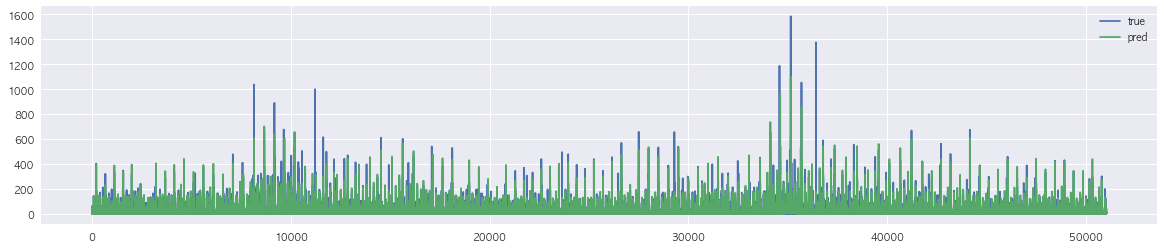

In [24]:
y_true, y_pred, fe, explainer1, shap_values1, X_train1 = location_ensemble2(bty_c0, xgb.XGBRegressor(learning_rate=0.3, max_depth=5, n_estimators=100, random_state=1234), shapvalue=True)

In [143]:
def prep_shapvalue(shapvalue, X, product=None) : 
    # Remove Categorical Columns 
    sm_cat_idx = [i for i,c in enumerate(X.columns) if 'sm_cat_' in c]
    sm_cat_col = [c for i,c in enumerate(X.columns) if 'sm_cat_' in c]
    
    # Remove Date Columns 
    date_idx = [i for i,c in enumerate(X.columns) if '연_' in c or '월_' in c or '분기' in c or '요일_' in c or 'age_' in c or 'sex' in c or '공휴일여부' in c or '주말여부' in c or 'ratio' in c ]
    date_col = [c for i,c in enumerate(X.columns) if '연_' in c or '월_' in c or '분기' in c or '요일_' in c or 'age_' in c or 'sex' in c or '공휴일여부' in c or '주말여부' in c or 'ratio' in c ]
    
    # ShapValue  
    shapvalue = shapvalue[:, np.delete(np.delete(np.arange(len(X.columns)), sm_cat_idx), date_idx)]
    X2 = X.drop(sm_cat_col+date_col, axis=1)
    
    # for Product ShapValue 
    if product : 
        idx = X[X[f"sm_cat_{product}"] == 1].index
        shapvalue = shapvalue[idx, :] ; X2 = X2.loc[idx]
    
    # Error Check 
    if shapvalue.shape != X2.shape : 
        raise Exception("Check Again!")
        
    return shapvalue, X2 

In [144]:
a, b = prep_shapvalue(shap_values1, X_train1)

In [145]:
a.shape, b.shape

((308824, 35), (308824, 35))

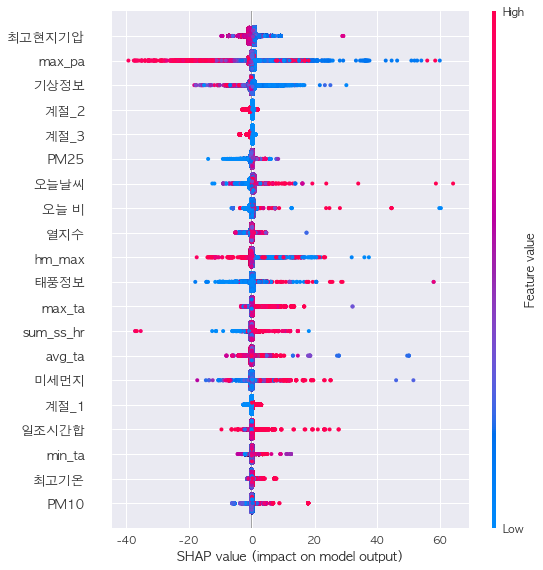

In [139]:
shap.summary_plot(a,b)

In [146]:
a, b = prep_shapvalue(shap_values1, X_train1, product="데오드란트")

In [147]:
a.shape, b.shape

((5205, 35), (5205, 35))

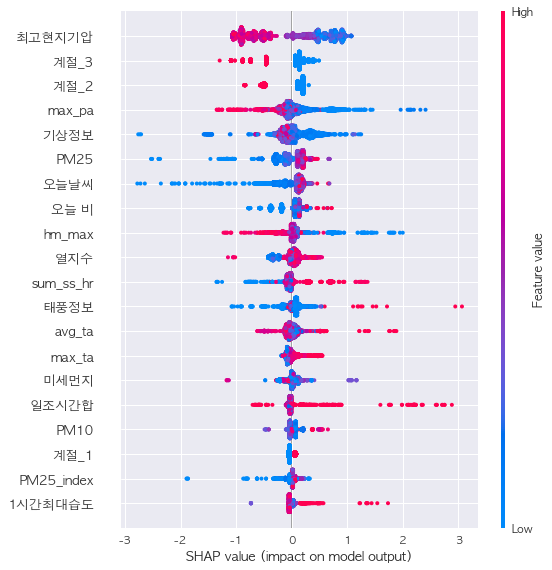

In [148]:
shap.summary_plot(a,b)

In [89]:
shap_values1.shape

(308824, 129)

In [25]:
shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values1[0,:], X_train1.iloc[0,:])

In [ ]:
# 전체 데이터에 대한 SHAP 시각화 : 핵 오래걸림 
shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values1, X_train1)

In [27]:
top_inds = np.argsort(-np.sum(np.abs(shap_values1), 0))
print(top_inds.shape)

(129,)


In [106]:
sm_cat_idx = [i for i,c in enumerate(X_train1.columns) if 'sm_cat_' in c]
sm_cat_col = [c for i,c in enumerate(X_train1.columns) if 'sm_cat_' in c]

In [109]:
date_idx = [i for i,c in enumerate(X_train1.columns) if '연_' in c or '월_' in c or '분기' in c or '요일_' in c or 'age_' in c or 'sex' in c or '공휴일여부' in c or '주말여부' in c or 'ratio' in c ]
date_col = [c for i,c in enumerate(X_train1.columns) if '연_' in c or '월_' in c or '분기' in c or '요일_' in c or 'age_' in c or 'sex' in c or '공휴일여부' in c or '주말여부' in c or 'ratio' in c ]

In [112]:
X_train1.drop(sm_cat_col+date_col, axis=1)

,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10_index,PM25_index,hm_max,sum_ss_hr,max_pa,1시간최대강수량,1시간최대습도,PM10,PM25,열지수,일별강수량,일조시간합,지점번호,체감온도,최고기온,최고현지기압,최저기온,평균기온,평균풍속,계절_1,계절_2,계절_3,강수여부,폭염여부
0,-1.260397,-0.512489,-0.611636,-0.690666,-0.354687,-1.432939,-1.430712,-1.381449,-0.387378,-0.450806,0.321078,0.368140,0.059594,-1.527428,0.656061,2.175767,-0.303935,-1.377049,0.032299,-0.153844,-1.425895,-0.291895,0.300061,0.000000,-1.251255,-1.374999,1.228085,-1.354618,-1.405428,-0.726315,0,0,1,0,0
1,-1.166643,-0.347094,-0.611636,-0.621723,-0.308203,-1.432939,-1.430712,-1.381449,-0.387378,-0.450806,0.321078,0.368140,0.059594,-1.527428,0.656061,2.175767,-0.303935,-1.377049,0.032299,-0.153844,-1.425895,-0.291895,0.300061,0.000000,-1.251255,-1.374999,1.228085,-1.354618,-1.405428,-0.726315,0,0,1,0,0
2,-1.134625,-0.454787,-0.611636,-0.636017,-0.360121,-1.432939,-1.430712,-1.381449,-0.387378,-0.450806,0.321078,0.368140,0.059594,-1.527428,0.656061,2.175767,-0.303935,-1.377049,0.032299,-0.153844,-1.425895,-0.291895,0.300061,0.000000,-1.251255,-1.374999,1.228085,-1.354618,-1.405428,-0.726315,0,0,1,0,0
3,-1.206552,-0.480155,-0.509924,-0.568449,-0.360121,-1.432939,-1.430712,-1.381449,-0.387378,-0.450806,0.321078,0.368140,0.059594,-1.527428,0.656061,2.175767,-0.303935,-1.377049,0.032299,-0.153844,-1.425895,-0.291895,0.300061,0.000000,-1.251255,-1.374999,1.228085,-1.354618,-1.405428,-0.726315,0,0,1,0,0
4,-1.085765,-0.411017,-0.611636,-0.690666,-0.360121,-1.432939,-1.430712,-1.381449,-0.387378,-0.450806,0.321078,0.368140,0.059594,-1.527428,0.656061,2.175767,-0.303935,-1.377049,0.032299,-0.153844,-1.425895,-0.291895,0.300061,0.000000,-1.251255,-1.374999,1.228085,-1.354618,-1.405428,-0.726315,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308819,1.806914,-0.473481,-0.611636,1.881193,-0.274924,-1.901355,-1.966339,-1.672612,-0.387378,-0.448202,2.250813,-0.968585,-0.850045,-1.554370,0.431245,0.179026,-0.303935,-0.670514,-0.650968,-0.562053,-2.107696,-0.291895,0.533858,0.000000,-2.297813,-2.129331,2.207294,-1.885111,-2.014005,2.077679,0,0,1,0,0
308820,-0.151977,-0.701952,-0.503786,-0.552781,-0.360121,-1.901355,-1.966339,-1.672612,-0.387378,-0.448202,2.250813,-0.968585,-0.850045,-1.554370,0.431245,0.179026,-0.303935,-0.670514,-0.650968,-0.562053,-2.107696,-0.291895,0.533858,0.000000,-2.297813,-2.129331,2.207294,-1.885111,-2.014005,2.077679,0,0,1,0,0
308821,0.507929,-0.691214,-0.611636,-0.417418,-0.360121,-1.901355,-1.966339,-1.672612,-0.387378,-0.448202,2.250813,-0.968585,-0.850045,-1.554370,0.431245,0.179026,-0.303935,-0.670514,-0.650968,-0.562053,-2.107696,-0.291895,0.533858,0.000000,-2.297813,-2.129331,2.207294,-1.885111,-2.014005,2.077679,0,0,1,0,0
308822,-0.300320,-0.718536,-0.498051,0.305171,-0.350183,-1.901355,-1.966339,-1.672612,-0.387378,-0.448202,2.250813,-0.968585,-0.850045,-1.554370,0.431245,0.179026,-0.303935,-0.670514,-0.650968,-0.562053,-2.107696,-0.291895,0.533858,0.000000,-2.297813,-2.129331,2.207294,-1.885111,-2.014005,2.077679,0,0,1,0,0


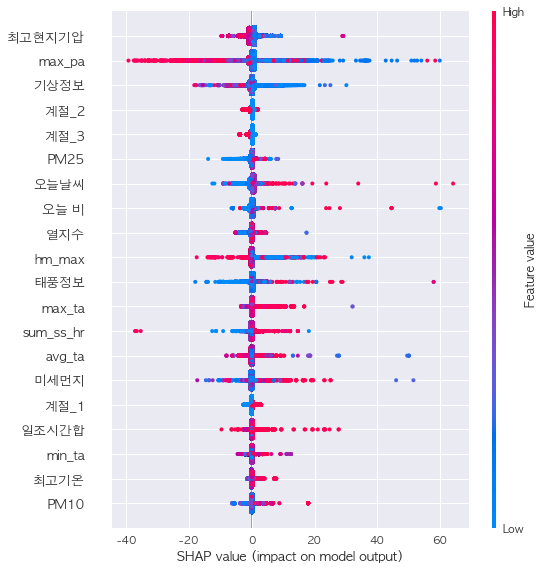

In [128]:
shap.summary_plot(shap_values1[:, np.delete(np.delete(np.arange(len(X_train1.columns)), sm_cat_idx), date_idx)], X_train1.drop(sm_cat_col+date_col, axis=1))

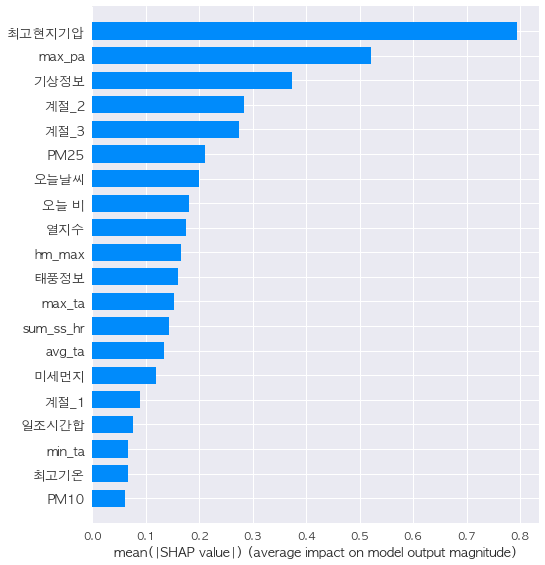

In [129]:
shap.summary_plot(shap_values1[:, np.delete(np.delete(np.arange(len(X_train1.columns)), sm_cat_idx), date_idx)], X_train1.drop(sm_cat_col+date_col, axis=1), plot_type='bar')

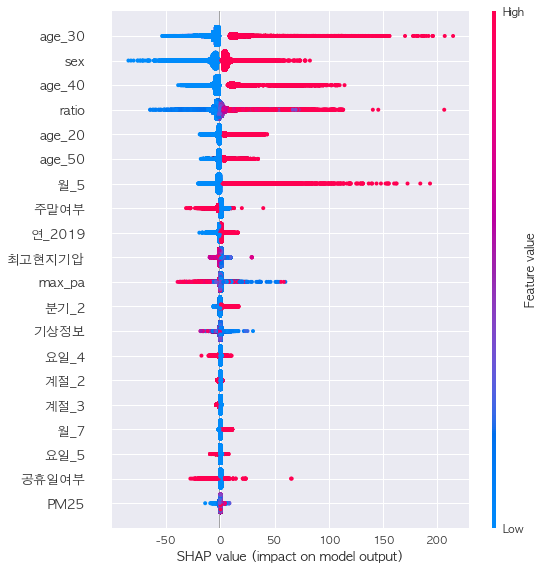

In [72]:
shap.summary_plot(np.concatenate((shap_values1[:, :62], shap_values1[:, 127:]), axis=1), X_train1.drop(sm_cat_col, axis=1))

In [78]:
check = X_train1[X_train1["sm_cat_데오드란트"] == 1].index

In [79]:
check

Int64Index([   107,    108,    109,    110,    111,    112,    113,    545,
               546,    547,
            ...
            308008, 308473, 308474, 308475, 308476, 308477, 308478, 308479,
            308480, 308481],
           dtype='int64', length=5205)

In [82]:
shap_values1[check, :62]

array([[-4.8013935e+00, -4.0327331e-01, -5.0843790e-02, ...,
        -3.6346385e+00, -2.5184774e+00, -1.0498062e+00],
       [-4.9412045e+00, -4.0566048e-01, -5.1663268e-02, ...,
         1.3401840e+01, -1.3881890e+00, -1.1564001e+00],
       [-5.3902187e+00, -1.7531000e-01, -4.0574178e-02, ...,
        -2.4590995e+00,  9.8458147e+00, -1.1466019e+00],
       ...,
       [-1.0172982e+00,  1.4989036e-01,  3.8946018e-02, ...,
        -2.0593202e+00,  8.9583368e+00, -1.0586350e+00],
       [ 9.7704314e-02,  8.6725421e-02,  1.1884897e-02, ...,
        -3.2890561e+00, -2.4414084e+00,  3.1800017e+00],
       [-1.5545535e+00,  9.0369232e-02,  7.7247089e-03, ...,
        -3.6877728e+00, -2.8406589e+00, -1.9062907e+00]], dtype=float32)

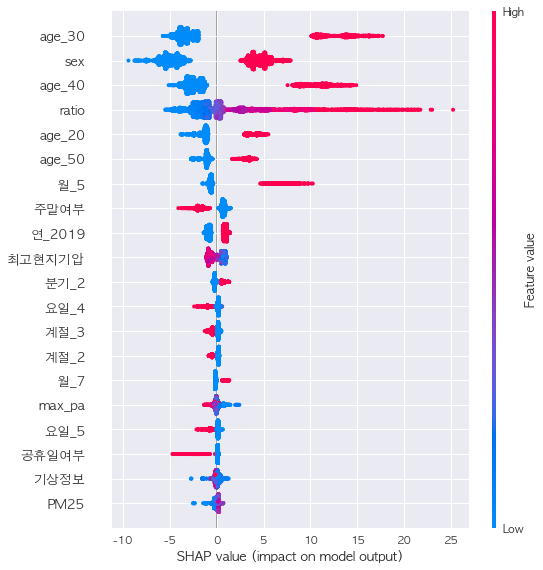

In [84]:
shap.summary_plot(np.concatenate((shap_values1[check, :62], shap_values1[check, 127:]), axis=1), X_train1.loc[check].drop(sm_cat_col, axis=1))

In [ ]:
# 데이터 하나만 보는게 아니라 전체를 보면 오래 걸림 ,,, 
shap.force_plot(explainer1.expected_value, np.concatenate((shap_values1[check, :62], shap_values1[check, 127:]), axis=1), X_train1.loc[check].drop(sm_cat_col, axis=1))

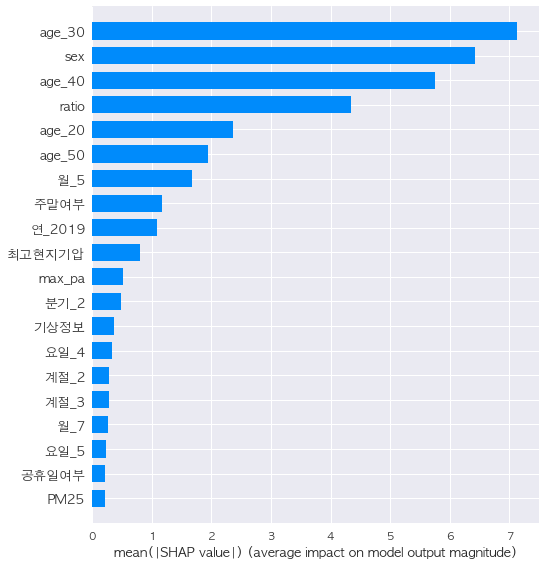

In [75]:
shap.summary_plot(np.concatenate((shap_values1[:, :62], shap_values1[:, 127:]), axis=1), X_train1.drop(sm_cat_col, axis=1), plot_type='bar')

In [31]:
result = pd.DataFrame({
    'rank' : top_inds, 'feature' : X_train1.columns
})

In [73]:
def feature_importance(f) : 
    f = f.reset_index()
    feature_importance = f.sort_values(by='feature importance', ascending=False)

    fig, ax = plt.subplots(figsize=(8,10))
    plot = sns.barplot(
                data = feature_importance[:50],
                x = "feature importance",
                y = "col", 
                palette=("Blues_d")
            )

    for p in plot.patches:
        x, y, width, height = p.get_bbox().bounds
        plot.text(width*1.01, y+height/2, width, va='center')

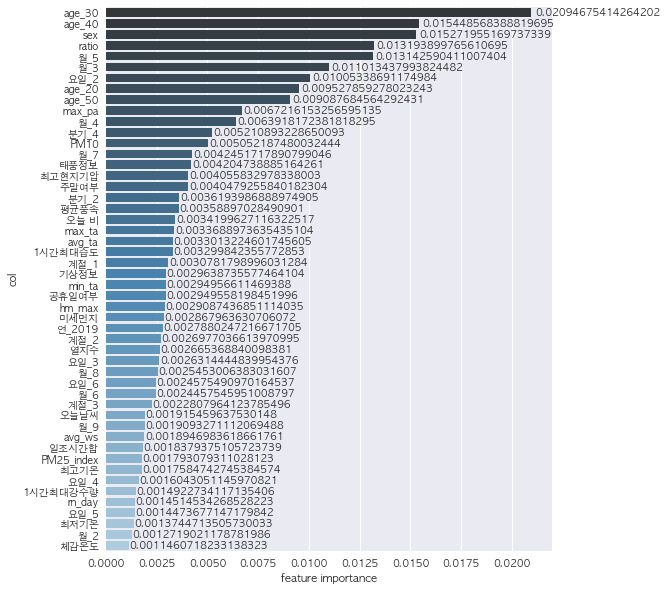

In [74]:
feature_importance(fe)

In [149]:
nonst_high = pd.read_csv("nonst_high_0619.csv", encoding="cp949")
nonst_causal = pd.read_csv("nonstationary_causality.csv", encoding="cp949")

In [150]:
nonst_high.sm_cat.nunique(), nonst_causal.sm_cat.nunique()

(134, 134)

In [154]:
bty_c0.head()

,date,sex,big_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10_index,PM25_index,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50,sm_cat_감자,sm_cat_건대추,sm_cat_건포도,sm_cat_계란,sm_cat_고추/피망/파프리카,sm_cat_공기정화 용품,sm_cat_기타 주스류,sm_cat_김치류,sm_cat_남성 선케어,sm_cat_냉풍기,sm_cat_네일 메이크업 용품,sm_cat_네일세트,sm_cat_네일아트,sm_cat_네일컬러,sm_cat_다이어트용 헬스보충식품,sm_cat_데오드란트,sm_cat_레몬/자몽,sm_cat_멀티형 에어컨,sm_cat_무김치,sm_cat_물김치,sm_cat_미나리,sm_cat_미숫가루/곡물가루,sm_cat_바디 클렌져,sm_cat_바디케어용 땀패드,sm_cat_바디케어용 제모제,sm_cat_배추김치,sm_cat_베이스 메이크업용 쿠션팩트,sm_cat_벽걸이 에어컨,sm_cat_벽걸이형 선풍기,sm_cat_뷰티 타투,sm_cat_뷰티용 여드름압출기,sm_cat_생수,sm_cat_샤워코롱,sm_cat_선로션,sm_cat_선스프레이,sm_cat_선케어용 선밤,sm_cat_선크림,sm_cat_스킨케어 코팩,sm_cat_스탠드형 냉온풍기,sm_cat_스탠드형 에어컨,sm_cat_아이스티,sm_cat_애프터선,sm_cat_업소용 선풍기,sm_cat_에어컨 리모컨,sm_cat_에이드,sm_cat_오이/가지,sm_cat_옥수수,sm_cat_온수매트,sm_cat_음용 식초,sm_cat_이동형 에어컨,sm_cat_이온음료,sm_cat_장어,sm_cat_제습기,sm_cat_참외/메론/수박,sm_cat_카페 푸드,sm_cat_카페트매트,sm_cat_키위/참다래,sm_cat_탁상/USB 선풍기,sm_cat_탄산수,sm_cat_탄산음료,sm_cat_토마토,sm_cat_파/양파,sm_cat_포도/거봉/체리,sm_cat_호박,sm_cat_휴대용 선풍기
0,2018-01-01,1,식품,6.000000,42.886220,10.693870,4.091370,0.000000,0.000000,0.044400,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-01,1,식품,9.000000,36.874165,12.429690,6.352940,0.000000,0.512820,0.424170,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-01,1,식품,10.000000,13.447085,13.022490,4.880370,0.000000,0.406500,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2018-01-01,1,식품,5.000000,7.296350,11.690800,4.533500,1.219510,0.909090,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2018-01-01,1,식품,3.000000,10.780135,13.927120,5.478870,0.000000,0.000000,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [157]:
ts_result2

,sm_cat,cluster
0,태닝용 선크림,2
1,가열식 가습기,3


In [158]:
ts_result2[ts_result2.sm_cat.isin(list(nonst_causal[nonst_causal.total > 0]["sm_cat"]))]

,sm_cat,cluster
1,가열식 가습기,3


In [153]:
list(nonst_causal[nonst_causal.total > 0]["sm_cat"])

['벽걸이 에어컨',
 '에어컨 리모컨',
 '음용 식초',
 '입욕제',
 '허브차',
 '가열식 가습기',
 '감귤/한라봉/오렌지',
 '건대추',
 '건어물 진미채',
 '견과류 밤',
 '곡물차',
 '기능성 아이케어 화장품',
 '기능성 화장품 세트',
 '기초 화장용 로션',
 '기초 화장용 미스트',
 '기초 화장용 크림',
 '기타 주스류',
 '난방용 열풍기',
 '남성 세트',
 '남성 쉐이빙',
 '느타리버섯',
 '데오드란트',
 '둥굴레차',
 '딸기/복분자/블루베리',
 '라디에이터',
 '루테인/눈 영양제',
 '명태/동태',
 '바디 보습제',
 '바디 클렌져',
 '바디케어용 땀패드',
 '바디케어용 제모제',
 '보리차',
 '복합식 가습기',
 '부추',
 '브로콜리/셀러리',
 '비타민',
 '색조 메이크업 립밤',
 '색조 메이크업 아이섀도우',
 '선스프레이',
 '선케어용 선밤',
 '소고기 육회',
 '쌈채소',
 '양배추/양상추',
 '어린이영양제',
 '에어워셔',
 '오메가3/스쿠알렌 영양제',
 '온수매트',
 '온열매트',
 '온풍기',
 '요거트/발효유',
 '유자차',
 '율무차',
 '자연식 가습기',
 '잡곡 씨드류',
 '장어',
 '전기온수기',
 '전기장판',
 '초음파식 가습기',
 '초코우유',
 '카페트매트',
 '칼슘/철분 영양제',
 '캡슐/POD커피',
 '컨벡터',
 '코코아/핫초코',
 '콜라겐/코큐텐 영양제',
 '클렌징 로션',
 '탁상/USB 선풍기',
 '탄산수',
 '파/양파',
 '파김치',
 '포도/거봉/체리',
 '프로폴리스/로얄젤리',
 '해초류 ',
 '핸드크림',
 '황토매트',
 '휴대용 선풍기',
 '히터']